<a href="https://www.arduino.cc/"><img src="https://raw.githubusercontent.com/sandeepmistry/aimldevfest-workshop-2019/master/images/Arduino_logo_R_highquality.png" width=200/></a>
# Tiny ML on Arduino
## Gesture Recognition
## To enable Wake on LAN for compatible systems

Modified code, based on Gesture Recognition Tutorial by Sandeep Mistry and Don Coleman. Details: https://github.com/arduino/ArduinoTensorFlowLiteTutorials/

## Setup Python Environment

In [ ]:
!pip install pandas numpy matplotlib
!pip install tensorflow

     |████████████████████████████████| 462 kB 24.9 MB/s 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf
import os

## Upload & Graph Data

In [ ]:
filename1 = "Twisting.csv"

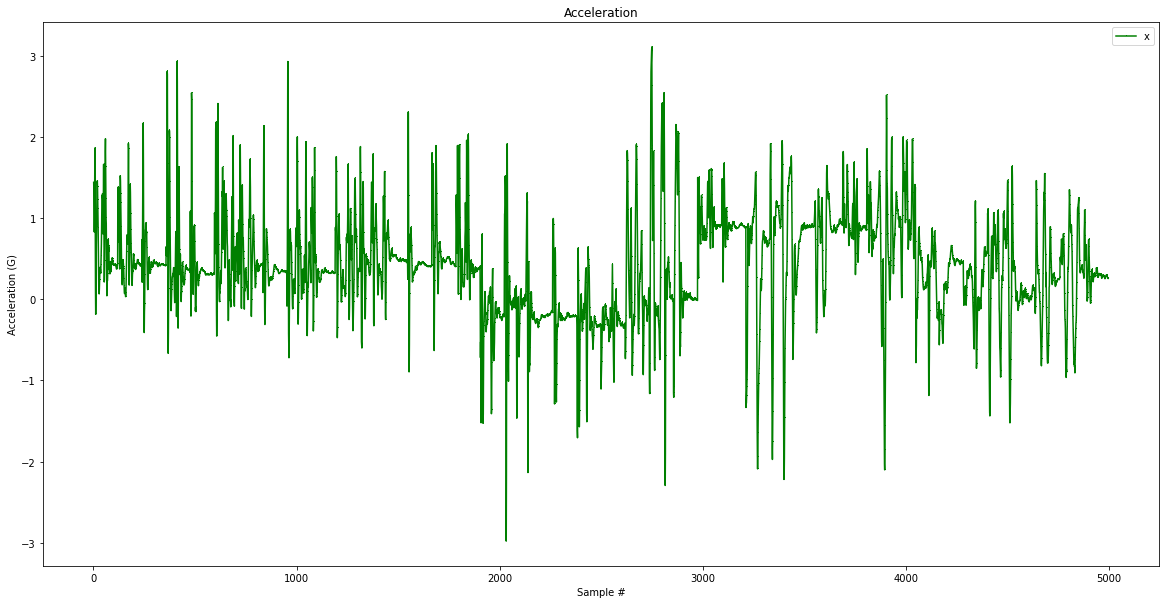

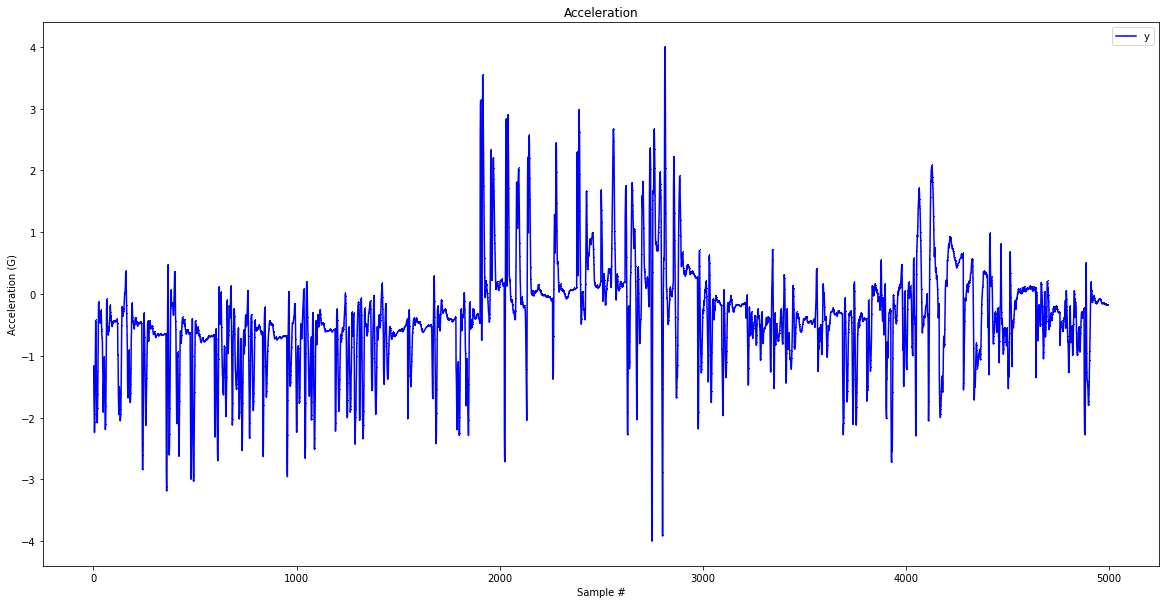

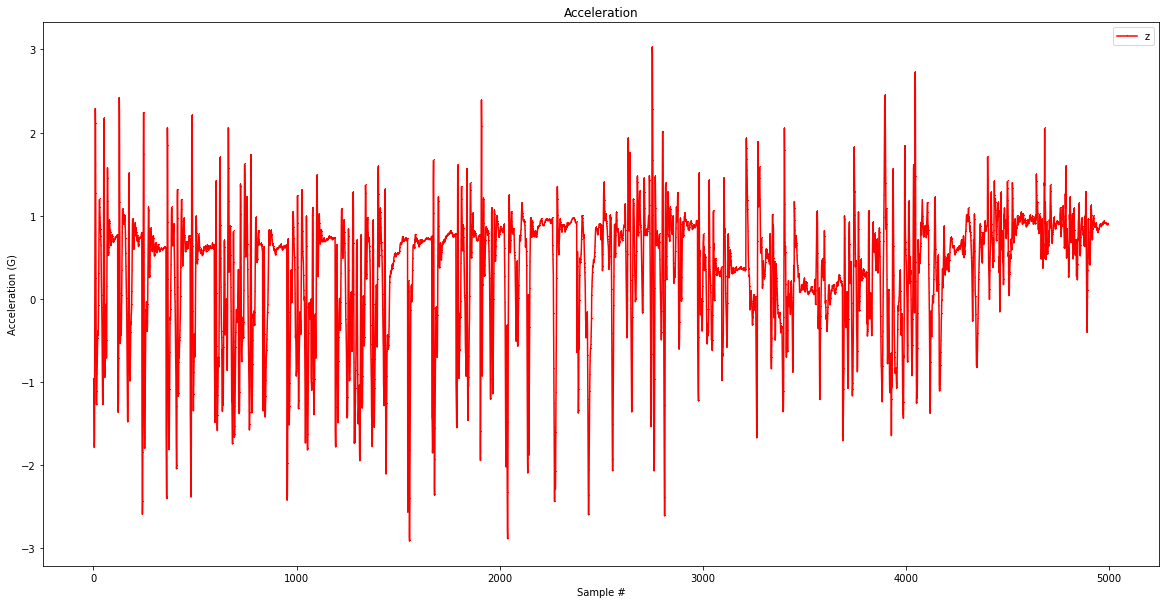

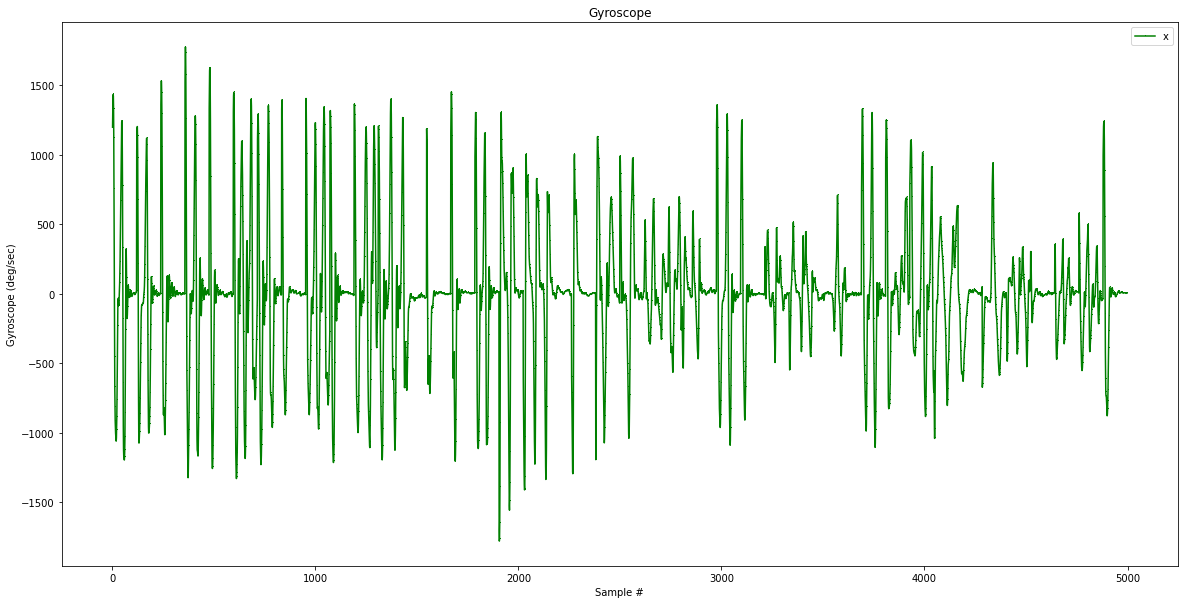

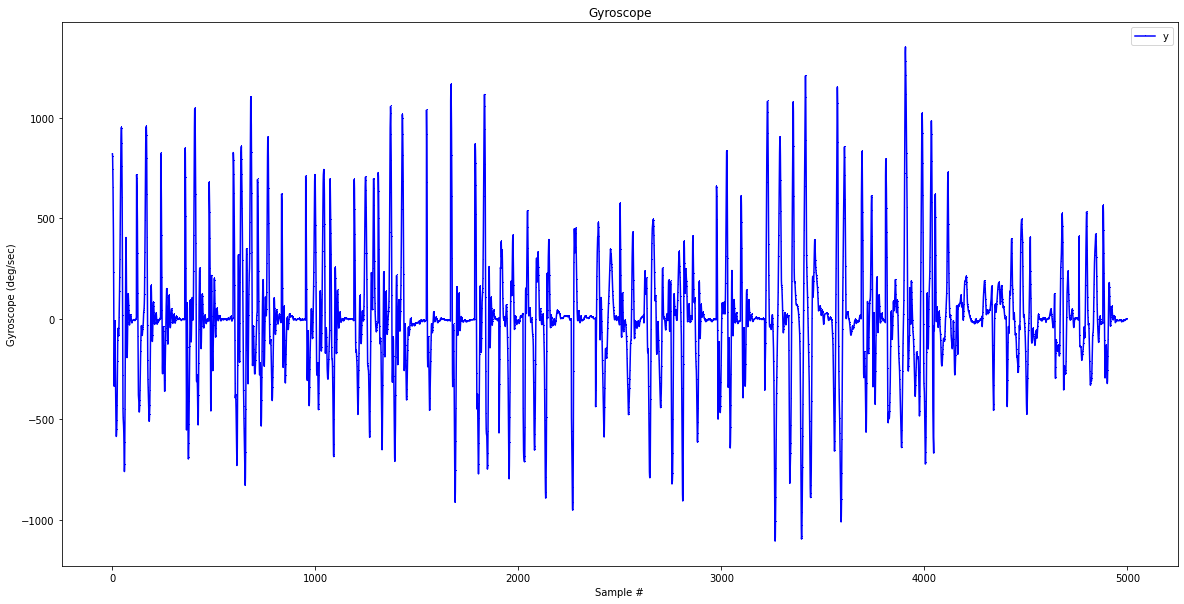

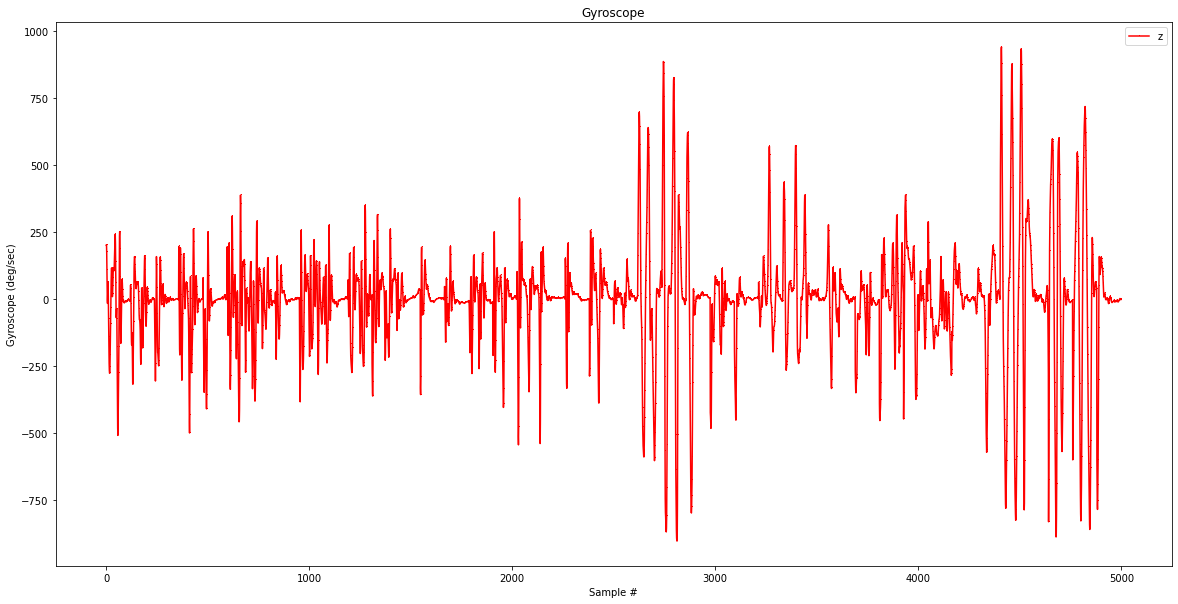

In [ ]:
df = pd.read_csv("/content/" + filename1)

index = range (1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()

plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()

plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()

In [ ]:
filename2 = "LiftUpDown.csv"

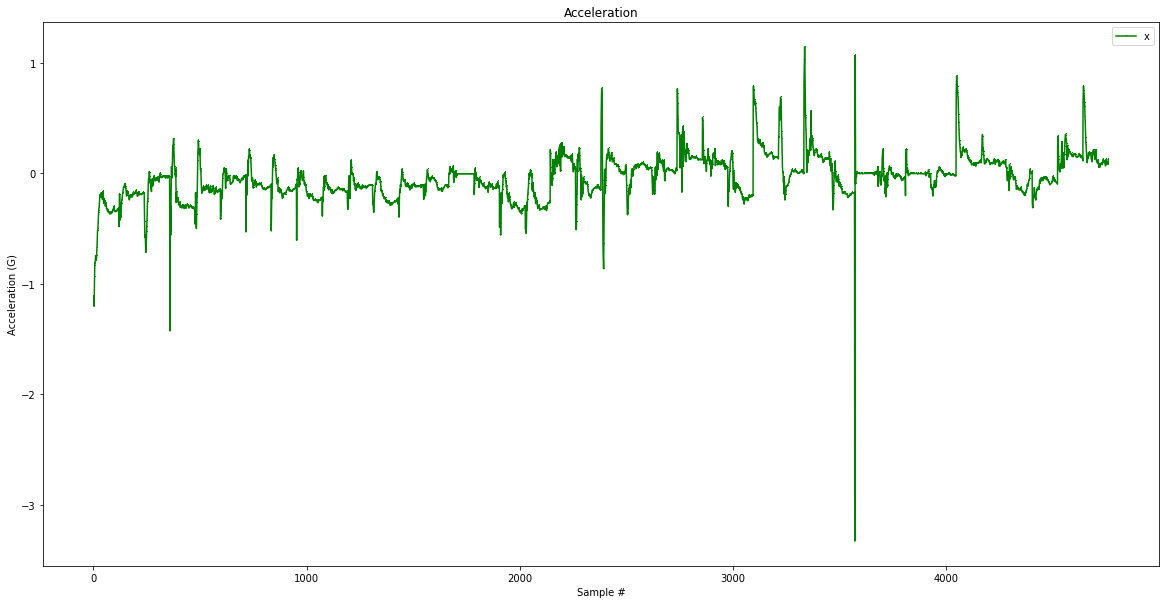

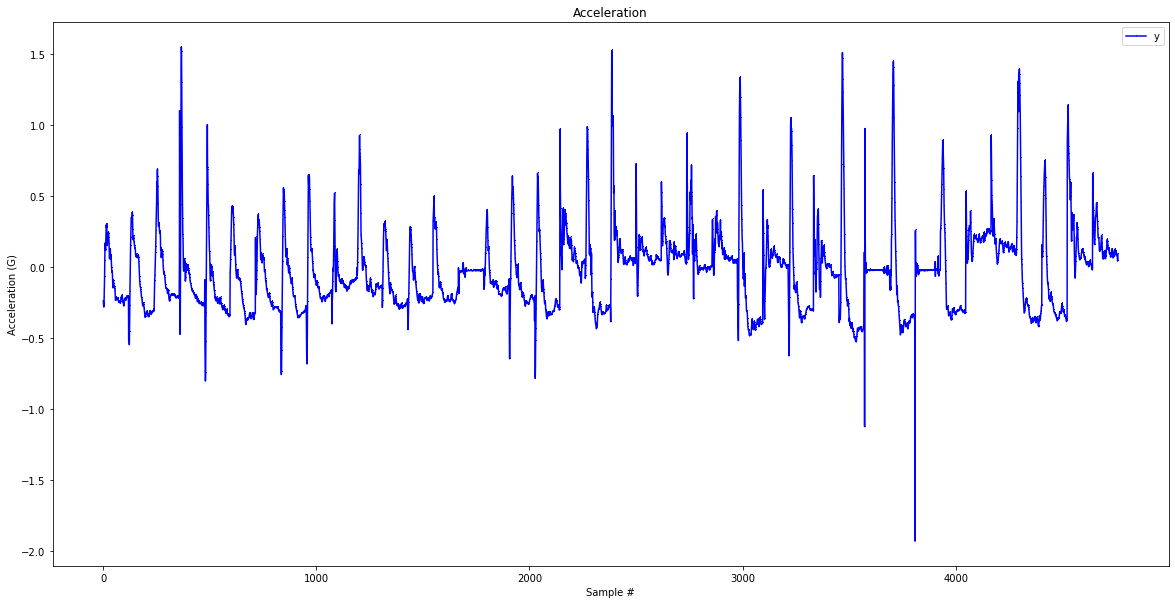

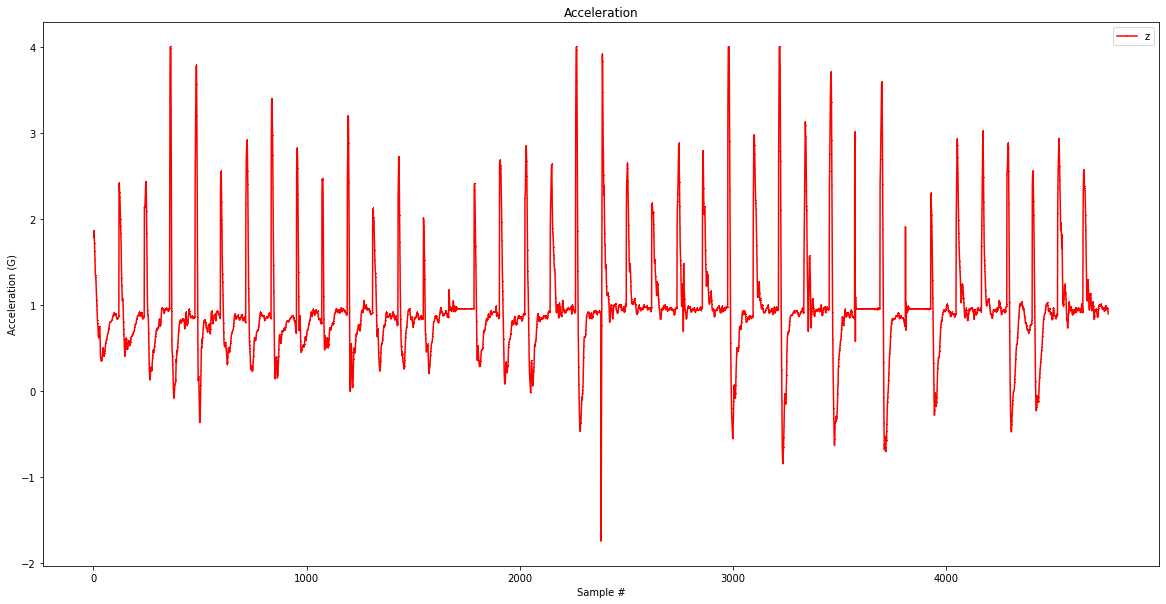

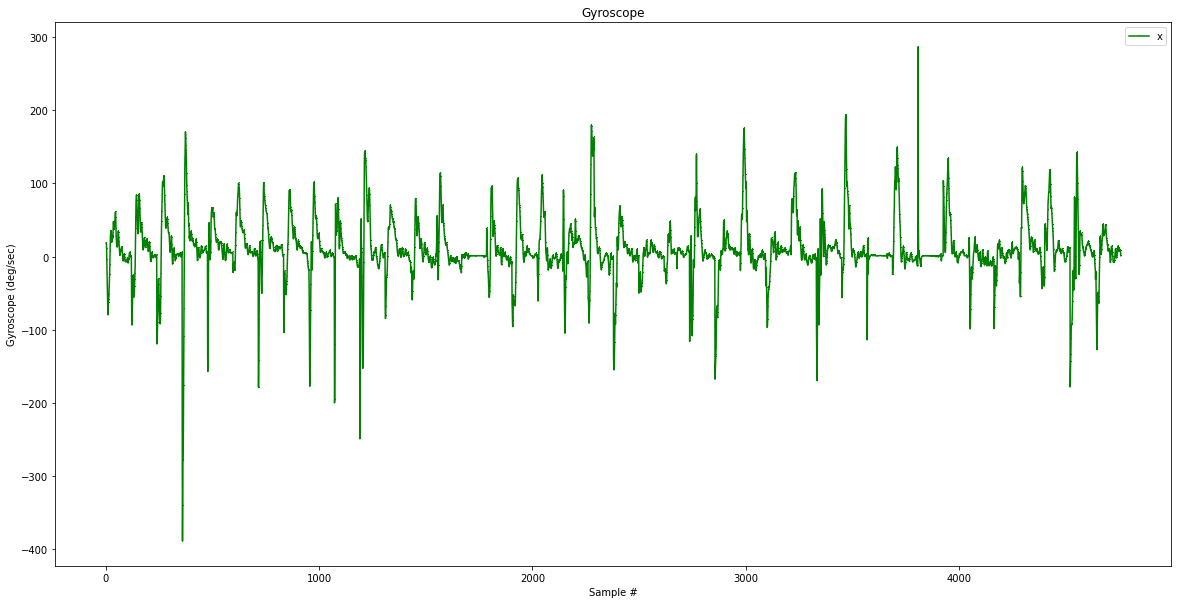

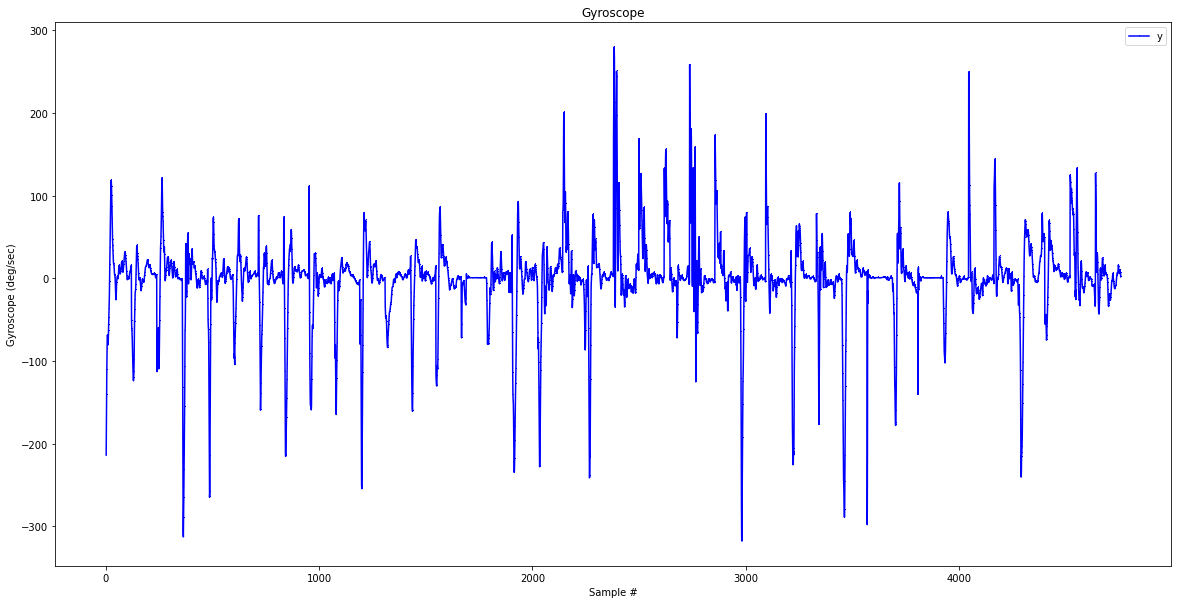

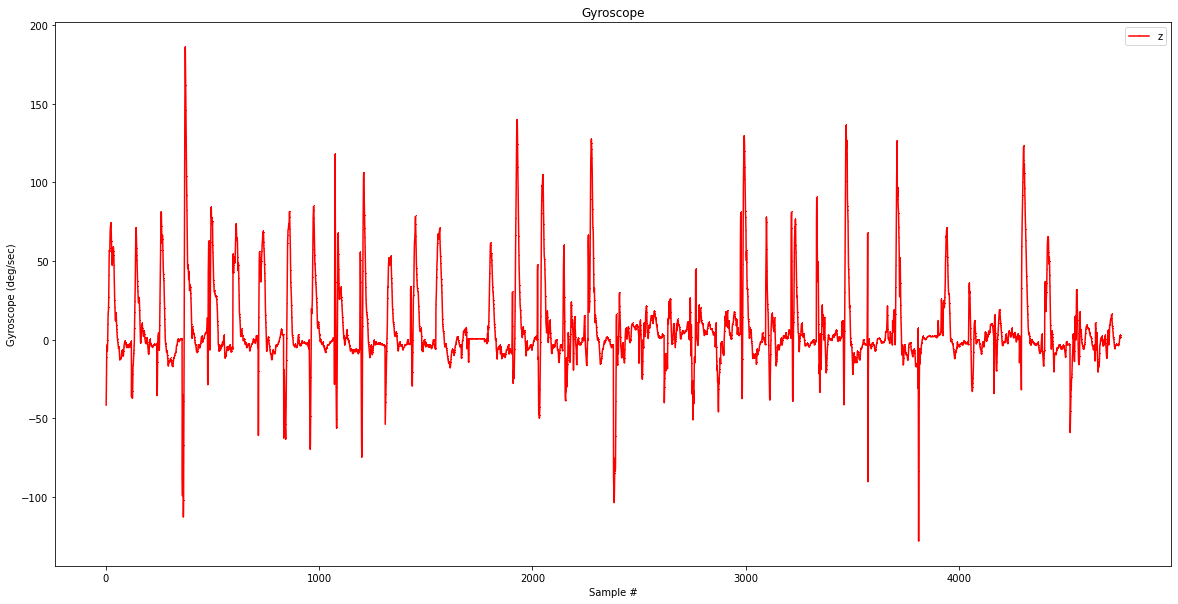

In [ ]:
df2 = pd.read_csv("/content/" + filename2)

index = range (1, len(df2['aX']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df2['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df2['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df2['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df2['gX'], 'g.', label='x', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()

plt.plot(index, df2['gY'], 'b.', label='y', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()

plt.plot(index, df2['gZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()

## Train Neural Network

### Parse and Prepare Data

The next cell parses the csv files and transforms them to a format that will be used to train the fully connected neural network.

In [ ]:
print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, allowing us to
# get the same random numbers each time the notebook runs

SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

#list of gestures that data is available for
GESTURES = ["Twisting", "LiftUpDown", ]

#For 119Hz sampling rate
SAMPLES_PER_GESTURE = 119

NUM_GESTURES = len(GESTURES)

# Create a one-hot encoded matrix, used in the output
ONE_HOT_ENCODED_GESTURE = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# Reading each CSV file and push an input and output
for gesture_index in range(NUM_GESTURES):
    gesture = GESTURES[gesture_index]
    print(f"Processing index {gesture_index} for gesture '{gesture}'.")
    
    output = ONE_HOT_ENCODED_GESTURE[gesture_index]
    
    df = pd.read_csv(gesture + ".csv")
    
    # Calculate number of gesture recordings in the file
    num_recordings = int (df.shape[0] / SAMPLES_PER_GESTURE)
    
    print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")
    
    for i in range (num_recordings):
        tensor = []
        for j in range(SAMPLES_PER_GESTURE):
            index = i* SAMPLES_PER_GESTURE + j
            # normalize the input data, between 0 and 1
            # - acceleration is between -4 and +4
            # - gyroscope is between -2000 and +2000
            
            tensor += [
                (df['aX'][index] + 4) / 8,
                (df['aY'][index] + 4) / 8,
                (df['aZ'][index] + 4) / 8,
                (df['gX'][index] + 2000) / 4000,
                (df['gY'][index] + 2000) / 4000,
                (df['gZ'][index] + 2000) / 4000,
            ]
            inputs.append(tensor)
            outputs.append(output)
            #inputs = np.append(inputs, tensor)
            #outputs = np.append(outputs, output)
        
#Converts list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Dataset parsing and preparation complete.")

TensorFlow version = 2.8.0

Processing index 0 for gesture 'Twisting'.
	There are 42 recordings of the Twisting gesture.
Processing index 1 for gesture 'LiftUpDown'.
	There are 40 recordings of the LiftUpDown gesture.
Dataset parsing and preparation complete.


## Randomize and split input and output pairs for training

Randomly split input and output pairs into sets of data:
- 60% training [For training of model]
- 20% validation [For measuring how well the model performs during training]
- 20% testing [To test the model after training]

In [ ]:
# Randomize the order of the inputs, alloweing for even distribution for training, validation and testing.
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0,1,2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

#Splitting the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


## Building & Training of Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras API](https://www.tensorflow.org/guide/keras).

### Model 1 
* 1 Hidden Layer (ReLU) with 30 neurons
* 1 Output Layer (ReLU) with 2 neurons (2 gestures)
* Optimizer: RMSProp, Loss: MSE, Metrics: MAE
* Epochs: 300, batch size: 5

Set as baseline

In [ ]:
#Build the model and train it
model1 = tf.keras.Sequential()
#Using ReLU for hidden layer 1
model1.add (tf.keras.layers.Dense(30, activation = 'relu'))
#ReLU for output layer
model1.add (tf.keras.layers.Dense(NUM_GESTURES, activation = 'relu'))

model1.compile(optimizer='rmsprop', loss = 'mse', metrics = ['mae'])

history1 = model1.fit(inputs_train, outputs_train, epochs = 300, batch_size=5, validation_data = (inputs_validate, outputs_validate))

Epoch 1/300
1171/1171 [==============================] - 3s 2ms/step - loss: 0.5000 - mae: 0.5000 - val_loss: 0.5000 - val_mae: 0.5000
Epoch 2/300
1171/1171 [==============================] - 3s 2ms/step - loss: 0.5000 - mae: 0.5000 - val_loss: 0.5000 - val_mae: 0.5000
Epoch 3/300
1171/1171 [==============================] - 3s 3ms/step - loss: 0.5000 - mae: 0.5000 - val_loss: 0.5000 - val_mae: 0.5000
Epoch 4/300
1171/1171 [==============================] - 3s 2ms/step - loss: 0.5000 - mae: 0.5000 - val_loss: 0.5000 - val_mae: 0.5000
Epoch 5/300
1171/1171 [==============================] - 3s 2ms/step - loss: 0.5000 - mae: 0.5000 - val_loss: 0.5000 - val_mae: 0.5000
Epoch 6/300
1171/1171 [==============================] - 3s 2ms/step - loss: 0.5000 - mae: 0.5000 - val_loss: 0.5000 - val_mae: 0.5000
Epoch 7/300
1171/1171 [==============================] - 2s 2ms/step - loss: 0.5000 - mae: 0.5000 - val_loss: 0.5000 - val_mae: 0.5000
Epoch 8/300
1171/1171 [==============================] 

### Verify
Graph the model's performance vs validation.

#### Graphing the loss
Graph the loss to see when the model stops improving.

Added SKIP=50 to show values from 51st epoch

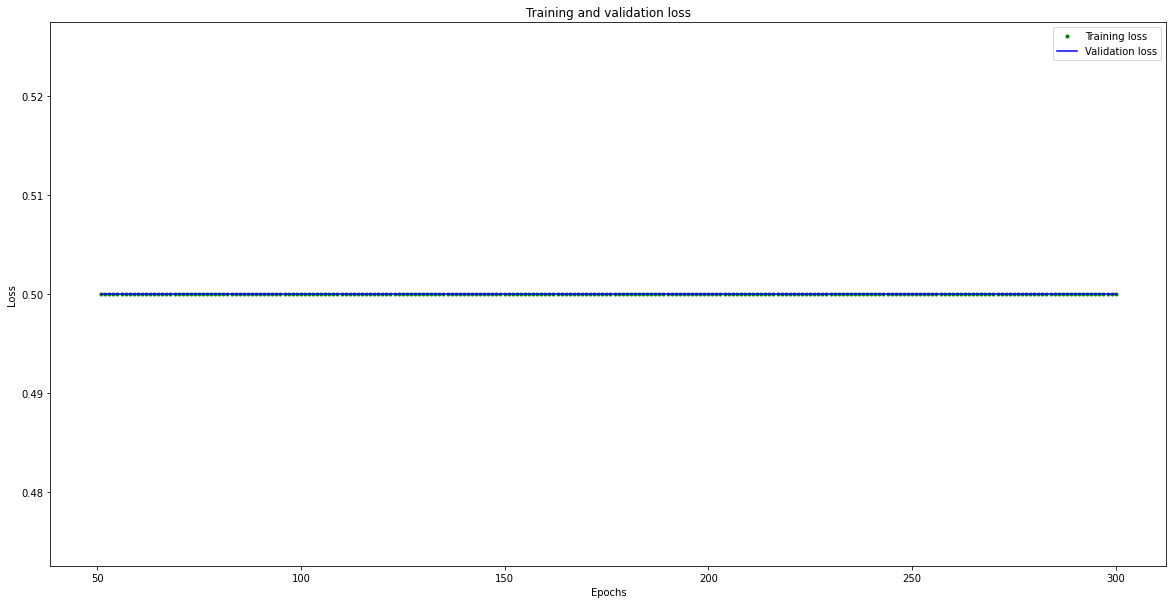

[20.0, 10.0]


In [ ]:
SKIP = 50

# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
epochs1 = range(1, len(loss1) + 1)
plt.plot(epochs1[SKIP:], loss1[SKIP:], 'g.', label='Training loss')
plt.plot(epochs1[SKIP:], val_loss1[SKIP:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

#### Graphing the MAE
Graph the Mean Absolute Error (MAE) to judge the performance of the model.

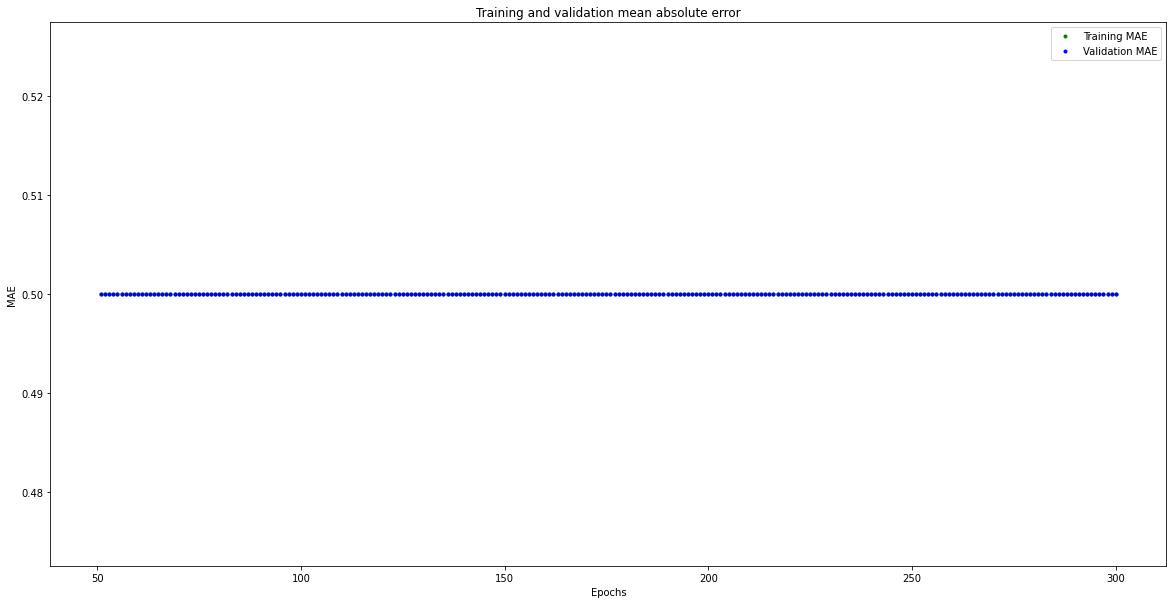

In [ ]:
# graph of mean absolute error
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
plt.plot(epochs1[SKIP:], mae1[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs1[SKIP:], val_mae1[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

#### Comments:
- Completely no improvement in epoch from 2nd epoch onwards.
- This might be code issue, or the current training is bad.
- Requires more indepth analysis.

### Model 2
* 1 Hidden Layer (ReLU) with 30 neurons
* 1 Output Layer (SoftMax) with 2 neurons (2 gestures)
* Optimizer: RMSProp, Loss: MSE, Metrics: MAE
* Epochs: 300, batch size: 5

##### Changed from ReLU to SoftMax for Output Layer as it is designed for probability

In [ ]:
#Build the model and train it
model2 = tf.keras.Sequential()
#Using ReLU for hidden layer 1
model2.add (tf.keras.layers.Dense(30, activation = 'relu'))
#SoftMax for output layer
model2.add (tf.keras.layers.Dense(NUM_GESTURES, activation = 'softmax'))

model2.compile(optimizer='rmsprop', loss = 'mse', metrics = ['mae'])

history2 = model2.fit(inputs_train, outputs_train, epochs = 300, batch_size=5, validation_data = (inputs_validate, outputs_validate))

Epoch 1/300
1171/1171 [==============================] - 3s 2ms/step - loss: 0.0909 - mae: 0.2335 - val_loss: 0.0292 - val_mae: 0.1083
Epoch 2/300
1171/1171 [==============================] - 2s 2ms/step - loss: 0.0193 - mae: 0.0648 - val_loss: 0.0065 - val_mae: 0.0336
Epoch 3/300
1171/1171 [==============================] - 2s 2ms/step - loss: 0.0121 - mae: 0.0378 - val_loss: 0.0066 - val_mae: 0.0297
Epoch 4/300
1171/1171 [==============================] - 2s 2ms/step - loss: 0.0105 - mae: 0.0281 - val_loss: 0.0012 - val_mae: 0.0109
Epoch 5/300
1171/1171 [==============================] - 2s 2ms/step - loss: 0.0070 - mae: 0.0204 - val_loss: 9.1250e-04 - val_mae: 0.0082
Epoch 6/300
1171/1171 [==============================] - 2s 2ms/step - loss: 0.0053 - mae: 0.0158 - val_loss: 3.9025e-04 - val_mae: 0.0060
Epoch 7/300
1171/1171 [==============================] - 2s 2ms/step - loss: 0.0054 - mae: 0.0139 - val_loss: 0.0233 - val_mae: 0.0401
Epoch 8/300
1171/1171 [========================

### Verify
Graph the model's performance vs validation.

#### Graphing the loss
Graph the loss to see when the model stops improving.

Added SKIP=75 to show values from 76th epoch

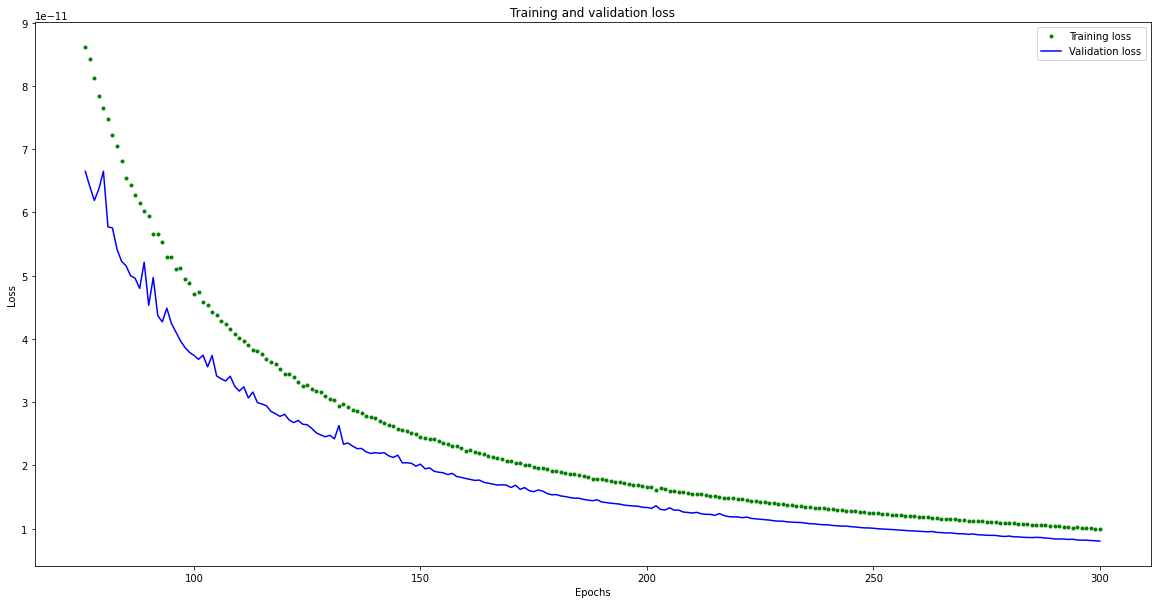

[20.0, 10.0]


In [ ]:
SKIP = 75

# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epochs2 = range(1, len(loss2) + 1)
plt.plot(epochs2[SKIP:], loss2[SKIP:], 'g.', label='Training loss')
plt.plot(epochs2[SKIP:], val_loss2[SKIP:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

#### Graphing the MAE
Graph the Mean Absolute Error (MAE) to judge the performance of the model.

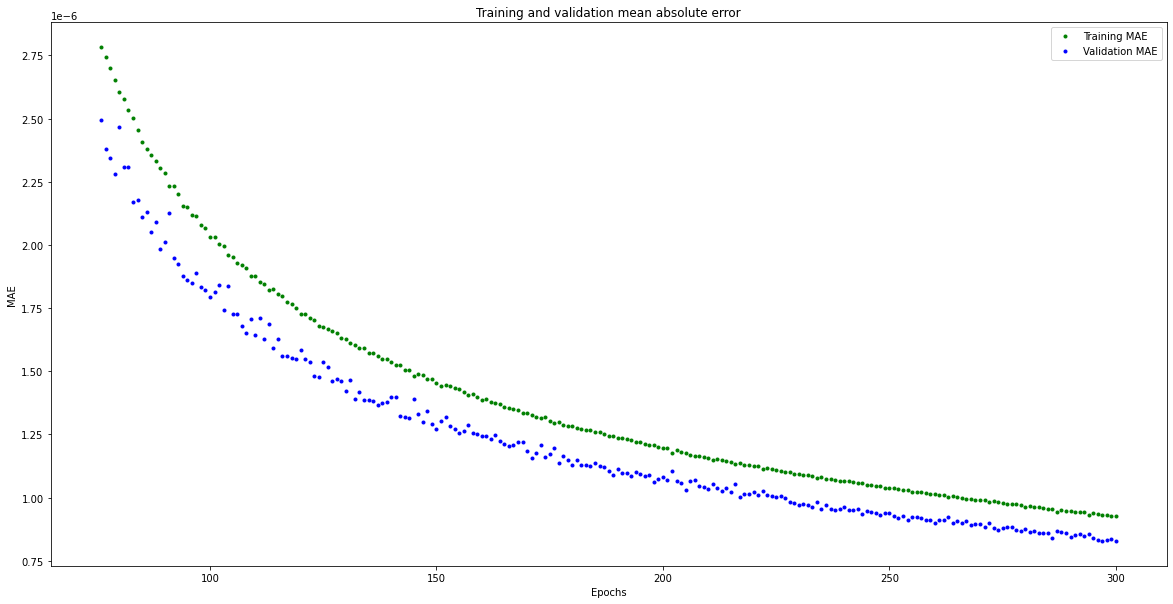

In [ ]:
# graph of mean absolute error
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
plt.plot(epochs2[SKIP:], mae2[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs2[SKIP:], val_mae2[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

#### Comments:
- Downward trend in training and validation loss/mae detected.
- Error rate drop significantly from 5x10^-1 to 4x10^-12 for loss, 5x10^-1 to 8x10^-7 for mae.
- Slight overfitting might have occured as the validation loss is consistently higher than training loss.

### Model 3
* 1 Hidden Layer (ReLU) with 30 neurons
* 1 Output Layer (SoftMax) with 2 neurons (2 gestures)
* Optimizer: RMSProp, Loss: MSE, Metrics: MAE
* Epochs: 800, batch size: 5

##### Increased the epoch to see if downward trend continues.

In [ ]:
#Build the model and train it
model3 = tf.keras.Sequential()
#Using ReLU for hidden layer 1 and 2
model3.add (tf.keras.layers.Dense(30, activation = 'relu'))
#SoftMax for output layer
model3.add (tf.keras.layers.Dense(NUM_GESTURES, activation = 'softmax'))

model3.compile(optimizer='rmsprop', loss = 'mse', metrics = ['mae'])

history3 = model3.fit(inputs_train, outputs_train, epochs = 800, batch_size=5, validation_data = (inputs_validate, outputs_validate))

Epoch 1/800
1171/1171 [==============================] - 3s 2ms/step - loss: 0.1002 - mae: 0.2566 - val_loss: 0.0208 - val_mae: 0.1036
Epoch 2/800
1171/1171 [==============================] - 2s 2ms/step - loss: 0.0201 - mae: 0.0761 - val_loss: 0.0078 - val_mae: 0.0432
Epoch 3/800
1171/1171 [==============================] - 2s 2ms/step - loss: 0.0116 - mae: 0.0421 - val_loss: 0.0133 - val_mae: 0.0455
Epoch 4/800
1171/1171 [==============================] - 2s 2ms/step - loss: 0.0089 - mae: 0.0297 - val_loss: 0.0013 - val_mae: 0.0141
Epoch 5/800
1171/1171 [==============================] - 3s 2ms/step - loss: 0.0060 - mae: 0.0213 - val_loss: 7.0571e-04 - val_mae: 0.0096
Epoch 6/800
1171/1171 [==============================] - 3s 2ms/step - loss: 0.0050 - mae: 0.0169 - val_loss: 6.4576e-04 - val_mae: 0.0082
Epoch 7/800
1171/1171 [==============================] - 3s 2ms/step - loss: 0.0046 - mae: 0.0142 - val_loss: 6.2583e-04 - val_mae: 0.0060
Epoch 8/800
1171/1171 [====================

### Verify
Graph the model's performance vs validation.

#### Graphing the loss
Graph the loss to see when the model stops improving.

Added SKIP=75 to show values from 76th epoch

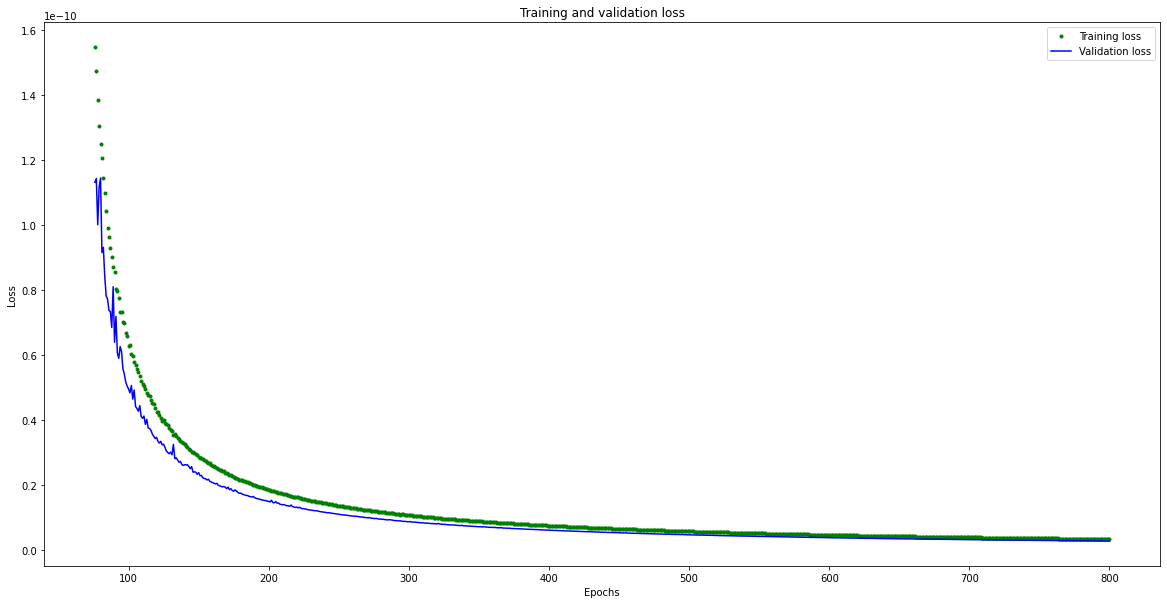

[20.0, 10.0]


In [ ]:
SKIP = 75

# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']
epochs3 = range(1, len(loss3) + 1)
plt.plot(epochs3[SKIP:], loss3[SKIP:], 'g.', label='Training loss')
plt.plot(epochs3[SKIP:], val_loss3[SKIP:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

#### Graphing the MAE
Graph the Mean Absolute Error (MAE) to judge the performance of the model.

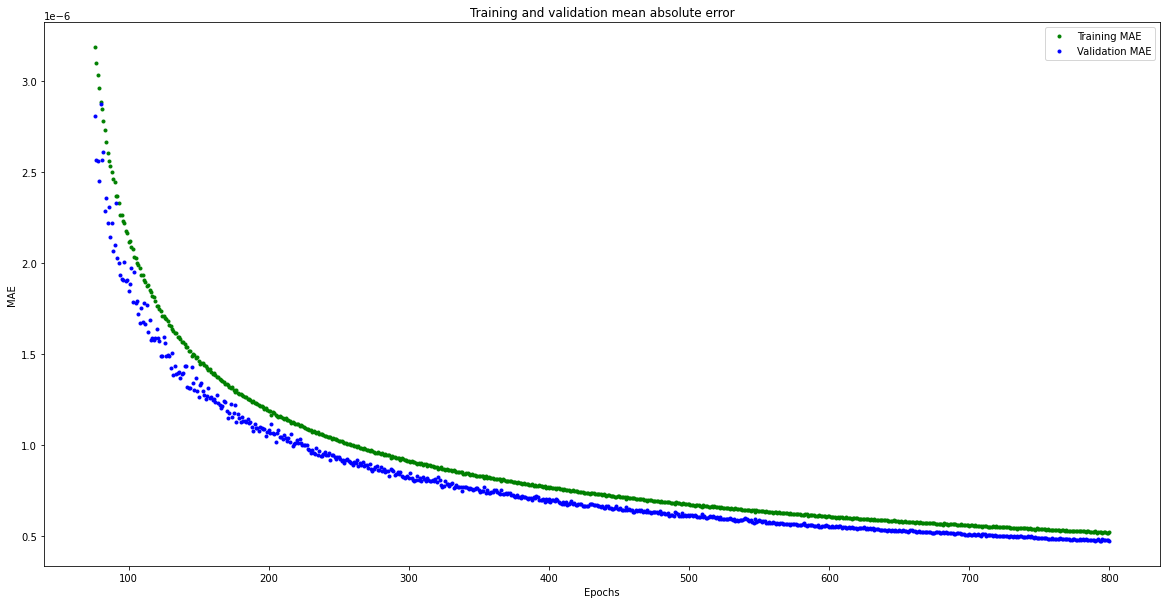

In [ ]:
# graph of mean absolute error
mae3 = history3.history['mae']
val_mae3 = history3.history['val_mae']
plt.plot(epochs3[SKIP:], mae3[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs3[SKIP:], val_mae3[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

#### Comments:
- Downward trend in training and validation loss/mae detected.
- However, the rate of change slowed significantly after 400 epoch.

### Model 4
* 2 Hidden Layer (ReLU) with 30 neurons
* 1 Output Layer (SoftMax) with 2 neurons (2 gestures)
* Optimizer: RMSProp, Loss: MSE, Metrics: MAE
* Epochs: 400, batch size: 5

##### Increased from 1 Hidden Layer to 2 Hidden Layers to see if accuracy improves.
##### Reduced Epoch from 800 to 400 to speed up on training.

In [ ]:
#Build the model and train it
model4 = tf.keras.Sequential()
#Using ReLU for hidden layer 1 & 2
model4.add (tf.keras.layers.Dense(30, activation = 'relu'))
model4.add (tf.keras.layers.Dense(30, activation = 'relu'))
#SoftMax for output layer
model4.add (tf.keras.layers.Dense(NUM_GESTURES, activation = 'softmax'))

model4.compile(optimizer='rmsprop', loss = 'mse', metrics = ['mae'])

history4 = model4.fit(inputs_train, outputs_train, epochs = 400, batch_size=5, validation_data = (inputs_validate, outputs_validate))

Epoch 1/400
1171/1171 [==============================] - 3s 2ms/step - loss: 0.0965 - mae: 0.2452 - val_loss: 0.0335 - val_mae: 0.1138
Epoch 2/400
1171/1171 [==============================] - 2s 2ms/step - loss: 0.0192 - mae: 0.0597 - val_loss: 0.0029 - val_mae: 0.0229
Epoch 3/400
1171/1171 [==============================] - 2s 2ms/step - loss: 0.0124 - mae: 0.0339 - val_loss: 0.0124 - val_mae: 0.0373
Epoch 4/400
1171/1171 [==============================] - 2s 2ms/step - loss: 0.0101 - mae: 0.0240 - val_loss: 0.0010 - val_mae: 0.0088
Epoch 5/400
1171/1171 [==============================] - 3s 2ms/step - loss: 0.0071 - mae: 0.0175 - val_loss: 0.0014 - val_mae: 0.0089
Epoch 6/400
1171/1171 [==============================] - 4s 3ms/step - loss: 0.0073 - mae: 0.0152 - val_loss: 1.3344e-04 - val_mae: 0.0035
Epoch 7/400
1171/1171 [==============================] - 2s 2ms/step - loss: 0.0064 - mae: 0.0122 - val_loss: 0.0262 - val_mae: 0.0376
Epoch 8/400
1171/1171 [============================

### Verify
Graph the model's performance vs validation.

#### Graphing the loss
Graph the loss to see when the model stops improving.

Added SKIP=75 to show values from 76th epoch

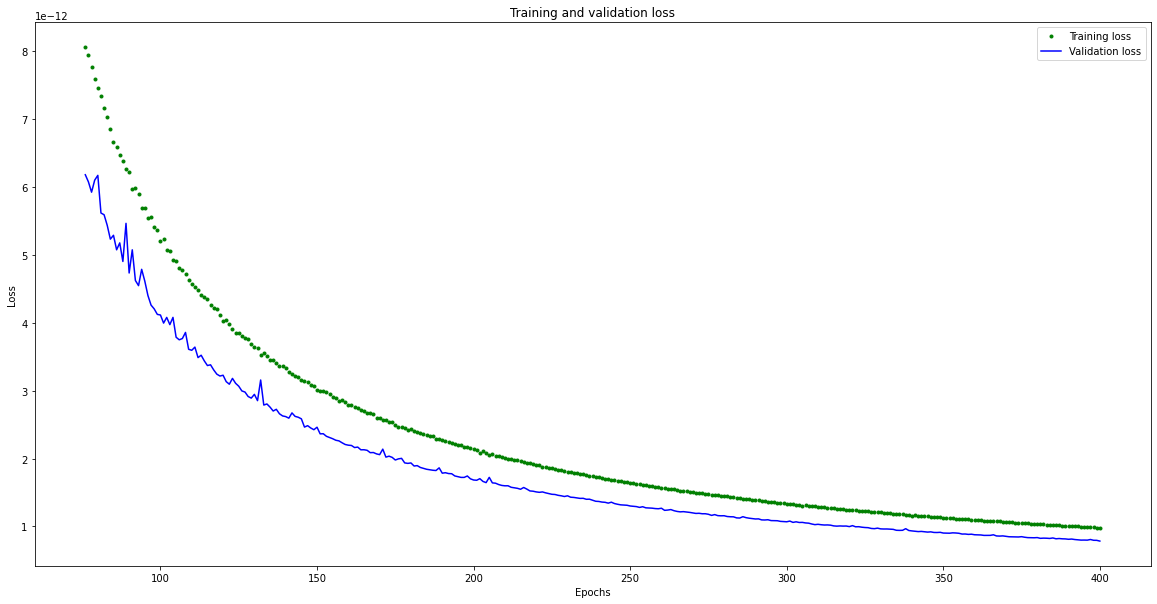

[20.0, 10.0]


In [ ]:
SKIP = 75

# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']
epochs4 = range(1, len(loss4) + 1)
plt.plot(epochs4[SKIP:], loss4[SKIP:], 'g.', label='Training loss')
plt.plot(epochs4[SKIP:], val_loss4[SKIP:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

#### Graphing the MAE
Graph the Mean Absolute Error (MAE) to judge the performance of the model.

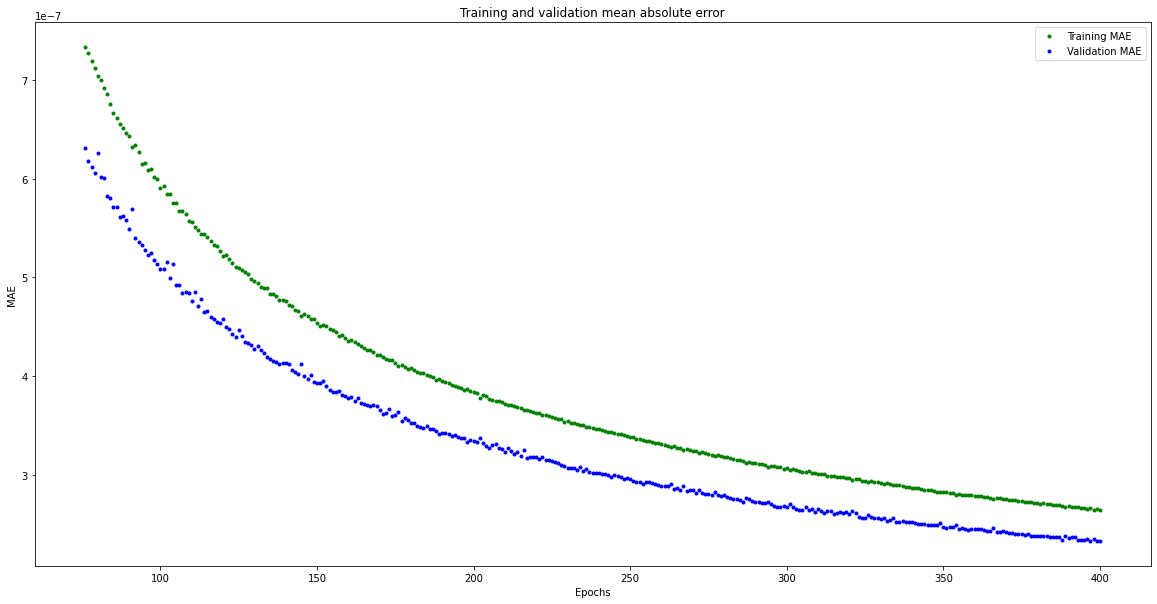

In [ ]:
# graph of mean absolute error
mae4 = history4.history['mae']
val_mae4 = history4.history['val_mae']
plt.plot(epochs4[SKIP:], mae4[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs4[SKIP:], val_mae4[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

#### Comments:
- Loss and MAE for both training and validation decreased even after epoch cut from 800 to 400.

### Model 5
* 2 Hidden Layer (ReLU) with 30 neurons
* 1 Output Layer (SoftMax) with 2 neurons (2 gestures)
* Optimizer: RMSProp, Loss: MSE, Metrics: MAE
* Epochs: 400, batch size: 1

##### Reduced batch size to 1 to see if accuracy improves.

In [ ]:
#Build the model and train it
model5 = tf.keras.Sequential()
#Using ReLU for hidden layer 1 & 2
model5.add (tf.keras.layers.Dense(30, activation = 'relu'))
model5.add (tf.keras.layers.Dense(30, activation = 'relu'))
#SoftMax for output layer
model5.add (tf.keras.layers.Dense(NUM_GESTURES, activation = 'softmax'))

model5.compile(optimizer='rmsprop', loss = 'mse', metrics = ['mae'])

history5 = model5.fit(inputs_train, outputs_train, epochs = 400, batch_size=1, validation_data = (inputs_validate, outputs_validate))

Epoch 1/400
5854/5854 [==============================] - 13s 2ms/step - loss: 0.0711 - mae: 0.1424 - val_loss: 0.0022 - val_mae: 0.0130
Epoch 2/400
5854/5854 [==============================] - 12s 2ms/step - loss: 0.0276 - mae: 0.0407 - val_loss: 0.0256 - val_mae: 0.0366
Epoch 3/400
5854/5854 [==============================] - 11s 2ms/step - loss: 0.0220 - mae: 0.0299 - val_loss: 0.0211 - val_mae: 0.0346
Epoch 4/400
5854/5854 [==============================] - 12s 2ms/step - loss: 0.0195 - mae: 0.0259 - val_loss: 7.9321e-05 - val_mae: 0.0013
Epoch 5/400
5854/5854 [==============================] - 11s 2ms/step - loss: 0.0110 - mae: 0.0150 - val_loss: 0.1755 - val_mae: 0.1814
Epoch 6/400
5854/5854 [==============================] - 12s 2ms/step - loss: 0.0123 - mae: 0.0149 - val_loss: 1.9031e-06 - val_mae: 2.2464e-04
Epoch 7/400
5854/5854 [==============================] - 11s 2ms/step - loss: 0.0118 - mae: 0.0147 - val_loss: 0.0526 - val_mae: 0.0646
Epoch 8/400
5854/5854 [=============

### Verify
Graph the model's performance vs validation.

#### Graphing the loss
Graph the loss to see when the model stops improving.

Added SKIP=75 to show values from 76th epoch

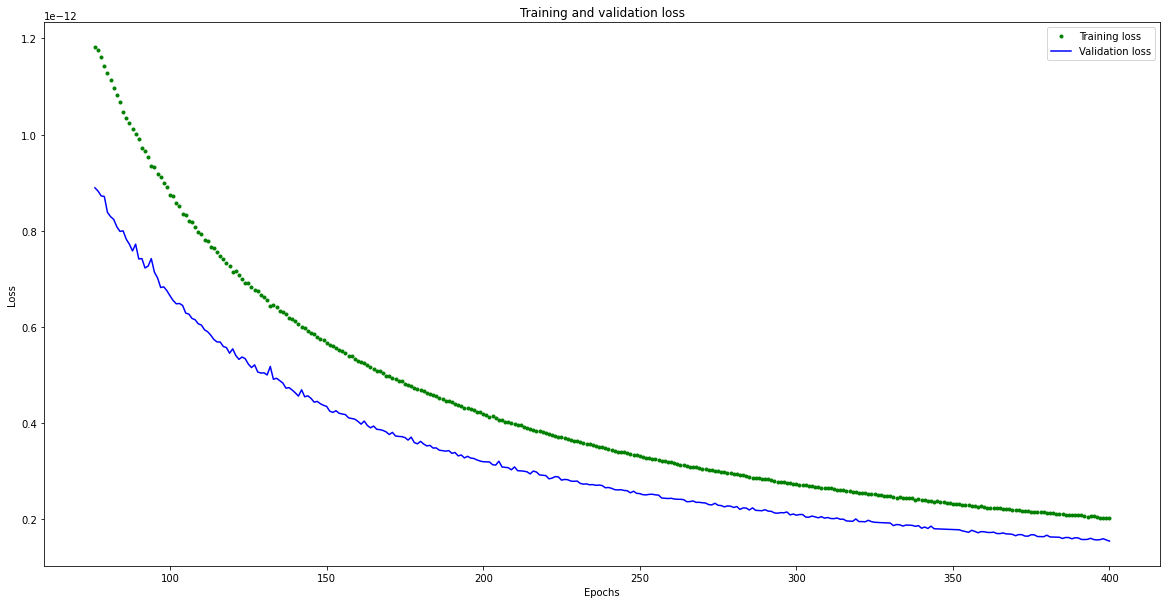

[20.0, 10.0]


In [ ]:
SKIP = 75

# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss5 = history5.history['loss']
val_loss5 = history5.history['val_loss']
epochs5 = range(1, len(loss5) + 1)
plt.plot(epochs5[SKIP:], loss5[SKIP:], 'g.', label='Training loss')
plt.plot(epochs5[SKIP:], val_loss5[SKIP:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

#### Graphing the MAE
Graph the Mean Absolute Error (MAE) to judge the performance of the model.

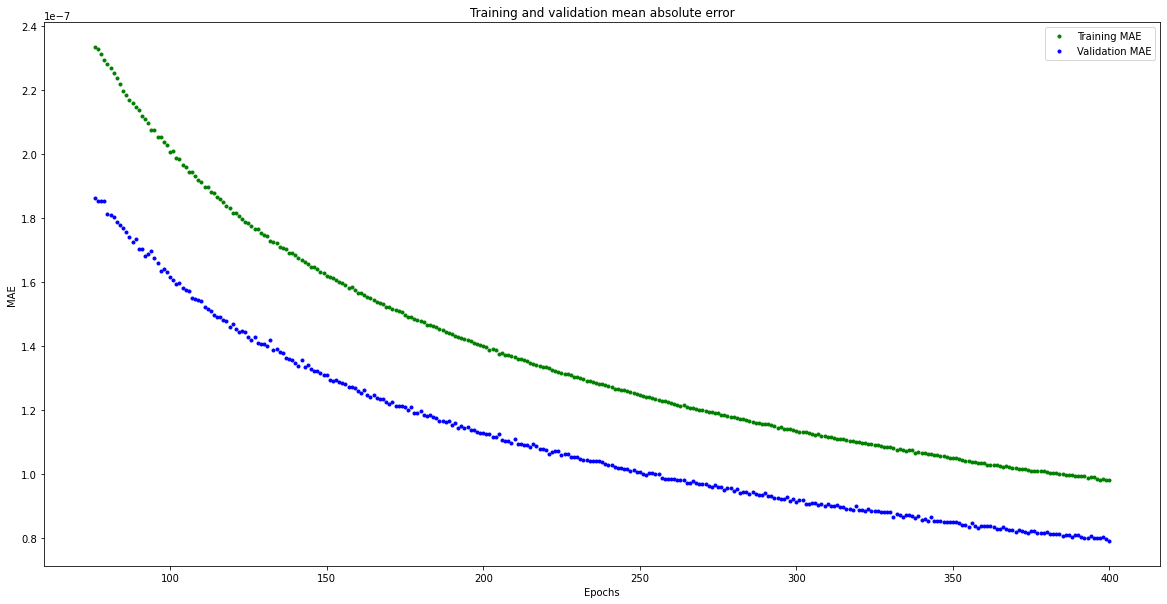

In [ ]:
# graph of mean absolute error
mae5 = history5.history['mae']
val_mae5 = history5.history['val_mae']
plt.plot(epochs5[SKIP:], mae5[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs5[SKIP:], val_mae5[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

#### Comments:
- Decreased in Batch Size increased training complexity significantly, causing training duration to increased from 2-4sec to 11-14sec per epoch.
- Loss and MAE for both training and validation decreased even further.
- Rate of change decreased after 250 epoch or so.
- Not worth the change as the existing accuracy is alr quite high.

### Model 6
* 2 Hidden Layer (ReLU) with 30 neurons
* 1 Output Layer (SoftMax) with 2 neurons (2 gestures)
* Optimizer: RMSProp, Loss: MSE, Metrics: Accuracy
* Epochs: 300, batch size: 5

##### Revert back to batch size of 5 to speedup training
##### Changed metrics from mae to accuracy
##### Reduced epoch to 300 as rate of change for model 4 and 5 slowed significantly by then

In [ ]:
#Build the model and train it
model6 = tf.keras.Sequential()
#Using ReLU for hidden layer 1 & 2
model6.add (tf.keras.layers.Dense(30, activation = 'relu'))
model6.add (tf.keras.layers.Dense(30, activation = 'relu'))
#SoftMax for output layer
model6.add (tf.keras.layers.Dense(NUM_GESTURES, activation = 'softmax'))

model6.compile(optimizer='rmsprop', loss = 'mse', metrics = ['accuracy'])

history6 = model6.fit(inputs_train, outputs_train, epochs = 300, batch_size=5, validation_data = (inputs_validate, outputs_validate))

Epoch 1/300
1171/1171 [==============================] - 3s 2ms/step - loss: 0.0847 - accuracy: 0.8796 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 2/300
1171/1171 [==============================] - 3s 2ms/step - loss: 0.0302 - accuracy: 0.9604 - val_loss: 0.1953 - val_accuracy: 0.6953
Epoch 3/300
1171/1171 [==============================] - 3s 2ms/step - loss: 0.0228 - accuracy: 0.9715 - val_loss: 0.0683 - val_accuracy: 0.8930
Epoch 4/300
1171/1171 [==============================] - 3s 2ms/step - loss: 0.0185 - accuracy: 0.9778 - val_loss: 2.5928e-04 - val_accuracy: 1.0000
Epoch 5/300
1171/1171 [==============================] - 2s 2ms/step - loss: 0.0113 - accuracy: 0.9857 - val_loss: 4.2190e-04 - val_accuracy: 1.0000
Epoch 6/300
1171/1171 [==============================] - 2s 2ms/step - loss: 0.0104 - accuracy: 0.9877 - val_loss: 5.2093e-06 - val_accuracy: 1.0000
Epoch 7/300
1171/1171 [==============================] - 2s 2ms/step - loss: 0.0079 - accuracy: 0.9901 - val_loss: 2.3

### Verify
Graph the model's performance vs validation.

#### Graphing the loss
Graph the loss to see when the model stops improving.

Added SKIP=75 to show values from 76th epoch

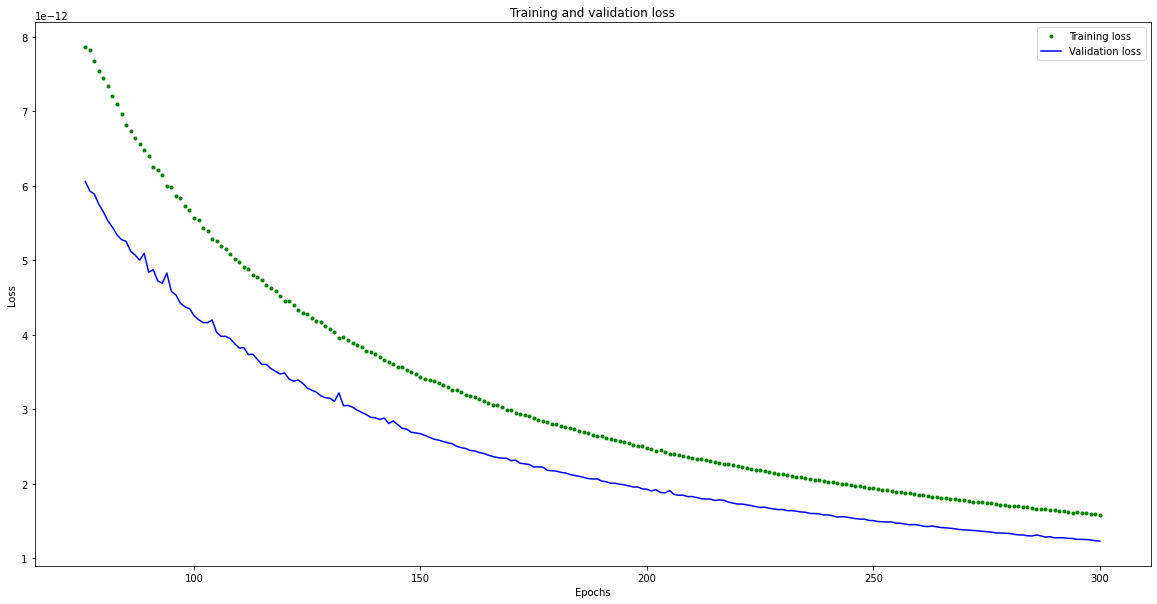

[20.0, 10.0]


In [ ]:
SKIP = 75

# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss6 = history6.history['loss']
val_loss6 = history6.history['val_loss']
epochs6 = range(1, len(loss6) + 1)
plt.plot(epochs6[SKIP:], loss6[SKIP:], 'g.', label='Training loss')
plt.plot(epochs6[SKIP:], val_loss6[SKIP:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

#### Graphing the Accuracy
Graph the Accuracy to judge the performance of the model.

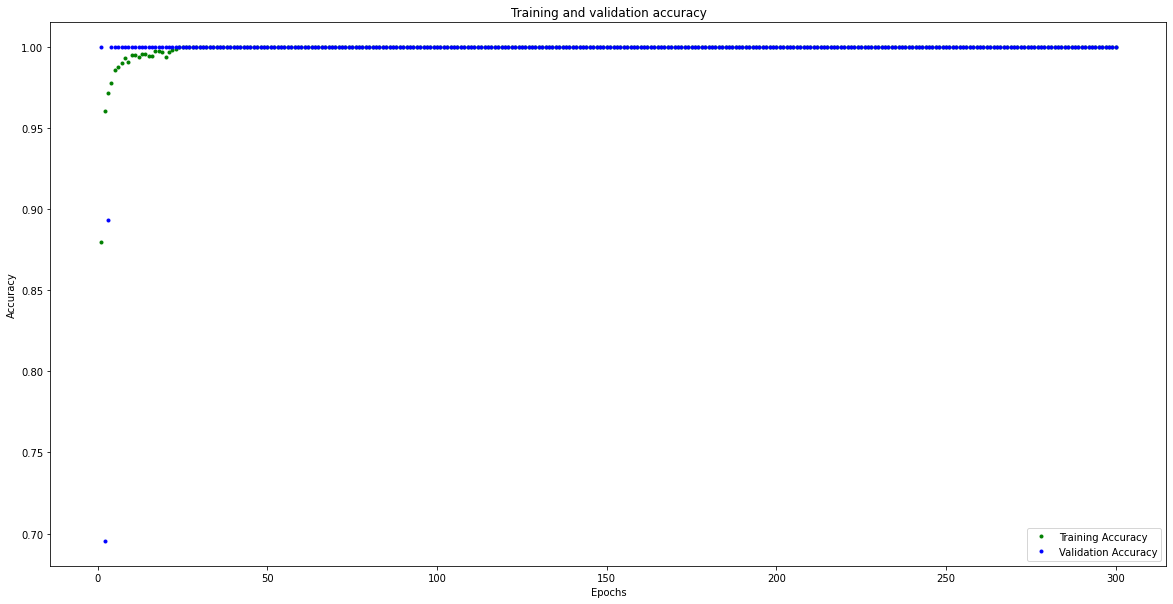

In [ ]:
# graph of accuracy
SKIP = 0

mae6 = history6.history['accuracy']
val_mae6 = history6.history['val_accuracy']
plt.plot(epochs6[SKIP:], mae6[SKIP:], 'g.', label='Training Accuracy')
plt.plot(epochs6[SKIP:], val_mae6[SKIP:], 'b.', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Comments:
- Comparing against Model 4, training and validation loss increased across the board.
- Accuracy has been stagnant at 1.0000 since epoch 25.
- Not a good metric it seems.

### Model 7
* 2 Hidden Layer (ReLU) with 30 neurons
* 1 Output Layer (SoftMax) with 2 neurons (2 gestures)
* Optimizer: Adam, Loss: MSE, Metrics: MAE
* Epochs: 300, batch size: 5

##### Changed Optimizer from RMSProp to Adam


In [ ]:
#Build the model and train it
model7 = tf.keras.Sequential()
#Using ReLU for hidden layer 1 & 2
model7.add (tf.keras.layers.Dense(30, activation = 'relu'))
model7.add (tf.keras.layers.Dense(30, activation = 'relu'))
#SoftMax for output layer
model7.add (tf.keras.layers.Dense(NUM_GESTURES, activation = 'softmax'))

model7.compile(optimizer='adam', loss = 'mse', metrics = ['mae'])

history7 = model7.fit(inputs_train, outputs_train, epochs = 300, batch_size=5, validation_data = (inputs_validate, outputs_validate))

Epoch 1/300
1171/1171 [==============================] - 35s 30ms/step - loss: 0.0707 - mae: 0.1863 - val_loss: 0.0063 - val_mae: 0.0436
Epoch 2/300
1171/1171 [==============================] - 3s 2ms/step - loss: 0.0141 - mae: 0.0446 - val_loss: 0.0015 - val_mae: 0.0172
Epoch 3/300
1171/1171 [==============================] - 3s 2ms/step - loss: 0.0081 - mae: 0.0251 - val_loss: 3.8884e-04 - val_mae: 0.0090
Epoch 4/300
1171/1171 [==============================] - 3s 2ms/step - loss: 0.0075 - mae: 0.0206 - val_loss: 1.9625e-04 - val_mae: 0.0069
Epoch 5/300
1171/1171 [==============================] - 3s 2ms/step - loss: 0.0027 - mae: 0.0094 - val_loss: 5.3804e-05 - val_mae: 0.0027
Epoch 6/300
1171/1171 [==============================] - 3s 2ms/step - loss: 4.6837e-05 - mae: 0.0021 - val_loss: 2.3318e-05 - val_mae: 0.0015
Epoch 7/300
1171/1171 [==============================] - 3s 2ms/step - loss: 2.1508e-05 - mae: 0.0013 - val_loss: 9.5501e-06 - val_mae: 8.5436e-04
Epoch 8/300
1171/1171

### Verify
Graph the model's performance vs validation.

#### Graphing the loss
Graph the loss to see when the model stops improving.

Added SKIP=75 to show values from 76th epoch

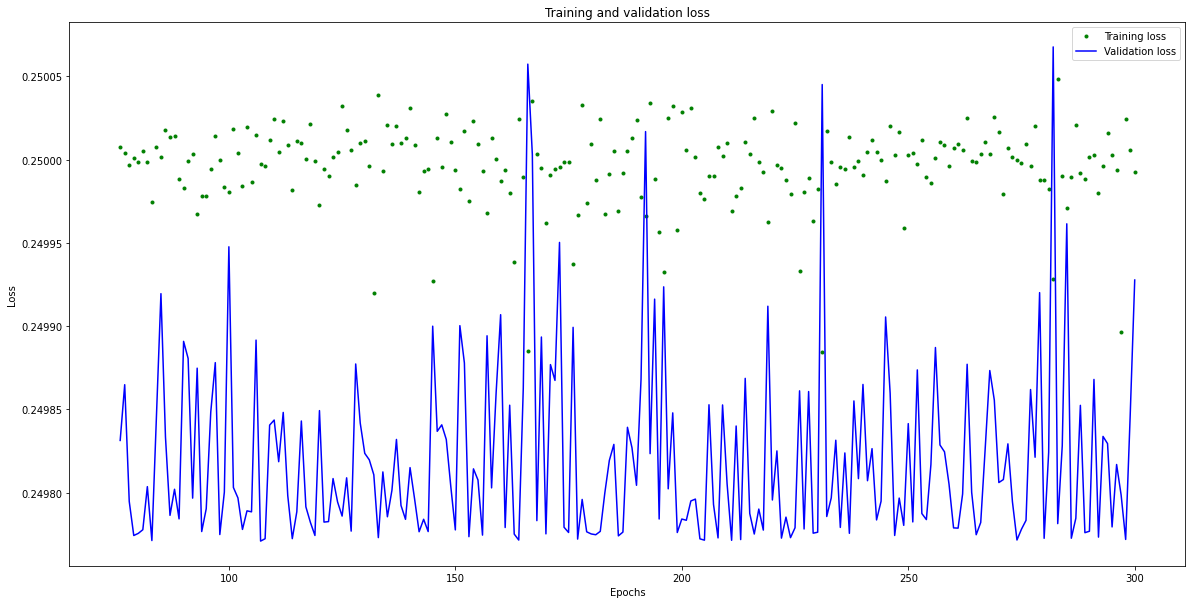

[20.0, 10.0]


In [ ]:
SKIP = 75

# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss7 = history7.history['loss']
val_loss7 = history7.history['val_loss']
epochs7 = range(1, len(loss7) + 1)
plt.plot(epochs7[SKIP:], loss7[SKIP:], 'g.', label='Training loss')
plt.plot(epochs7[SKIP:], val_loss7[SKIP:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

#### Graphing the Accuracy
Graph the Accuracy to judge the performance of the model.

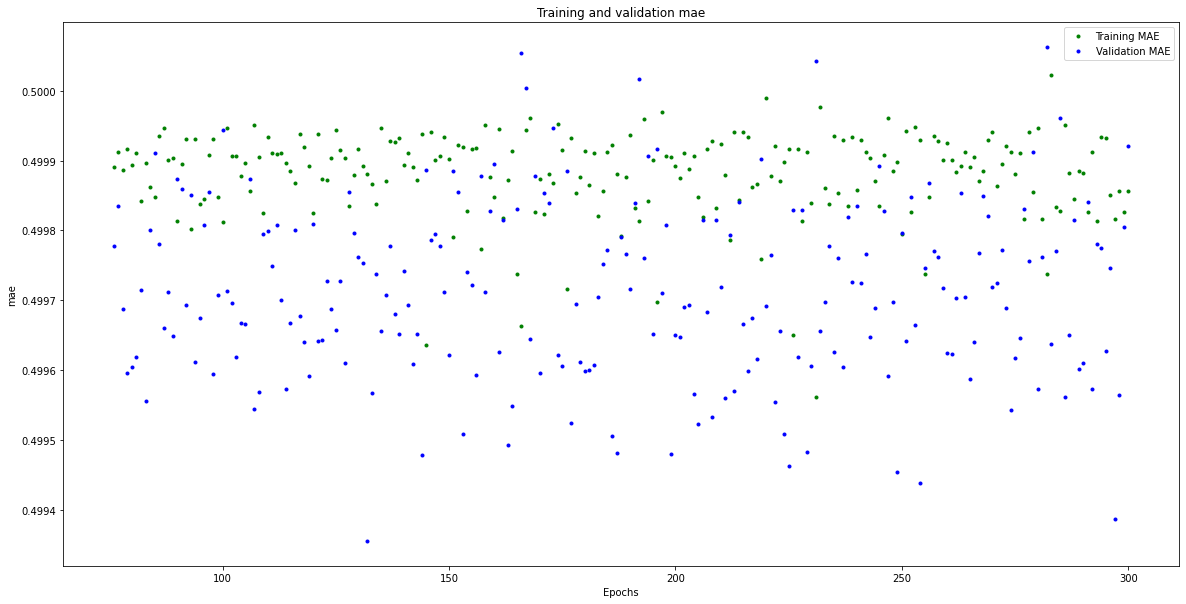

In [ ]:
# graph of mean absolute error
mae7 = history7.history['mae']
val_mae7 = history7.history['val_mae']
plt.plot(epochs7[SKIP:], mae7[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs7[SKIP:], val_mae7[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

#### Comments:
- Bad training and validation results detected.
- Adam is primarily used for Computer Vision and Natural Language Processing.
- Therefore, this model is unusable for this application.

### Model 8
* 2 Hidden Layer (ReLU) with 60 neurons
* 1 Output Layer (SoftMax) with 2 neurons (2 gestures)
* Optimizer: RMSProp, Loss: MSE, Metrics: MAE
* Epochs: 300, batch size: 5

##### Increased neuron count from 30 to 60 to see if it affects training results.

In [ ]:
#Build the model and train it
model8 = tf.keras.Sequential()
#Using ReLU for hidden layer 1 & 2
model8.add (tf.keras.layers.Dense(60, activation = 'relu'))
model8.add (tf.keras.layers.Dense(60, activation = 'relu'))
#SoftMax for output layer
model8.add (tf.keras.layers.Dense(NUM_GESTURES, activation = 'softmax'))

model8.compile(optimizer='rmsprop', loss = 'mse', metrics = ['mae'])

history8 = model8.fit(inputs_train, outputs_train, epochs = 300, batch_size=5, validation_data = (inputs_validate, outputs_validate))

Epoch 1/300
1171/1171 [==============================] - 4s 3ms/step - loss: 0.0860 - mae: 0.1947 - val_loss: 0.0070 - val_mae: 0.0437
Epoch 2/300
1171/1171 [==============================] - 3s 2ms/step - loss: 0.0285 - mae: 0.0595 - val_loss: 0.0638 - val_mae: 0.1002
Epoch 3/300
1171/1171 [==============================] - 3s 2ms/step - loss: 0.0215 - mae: 0.0406 - val_loss: 0.1535 - val_mae: 0.1751
Epoch 4/300
1171/1171 [==============================] - 3s 2ms/step - loss: 0.0190 - mae: 0.0317 - val_loss: 5.7494e-04 - val_mae: 0.0057
Epoch 5/300
1171/1171 [==============================] - 3s 2ms/step - loss: 0.0126 - mae: 0.0192 - val_loss: 3.3138e-05 - val_mae: 0.0018
Epoch 6/300
1171/1171 [==============================] - 3s 2ms/step - loss: 0.0089 - mae: 0.0131 - val_loss: 6.0007e-06 - val_mae: 4.9732e-04
Epoch 7/300
1171/1171 [==============================] - 3s 2ms/step - loss: 0.0118 - mae: 0.0152 - val_loss: 0.0026 - val_mae: 0.0075
Epoch 8/300
1171/1171 [================

### Verify
Graph the model's performance vs validation.

#### Graphing the loss
Graph the loss to see when the model stops improving.

Added SKIP=50 to show values from 51st epoch

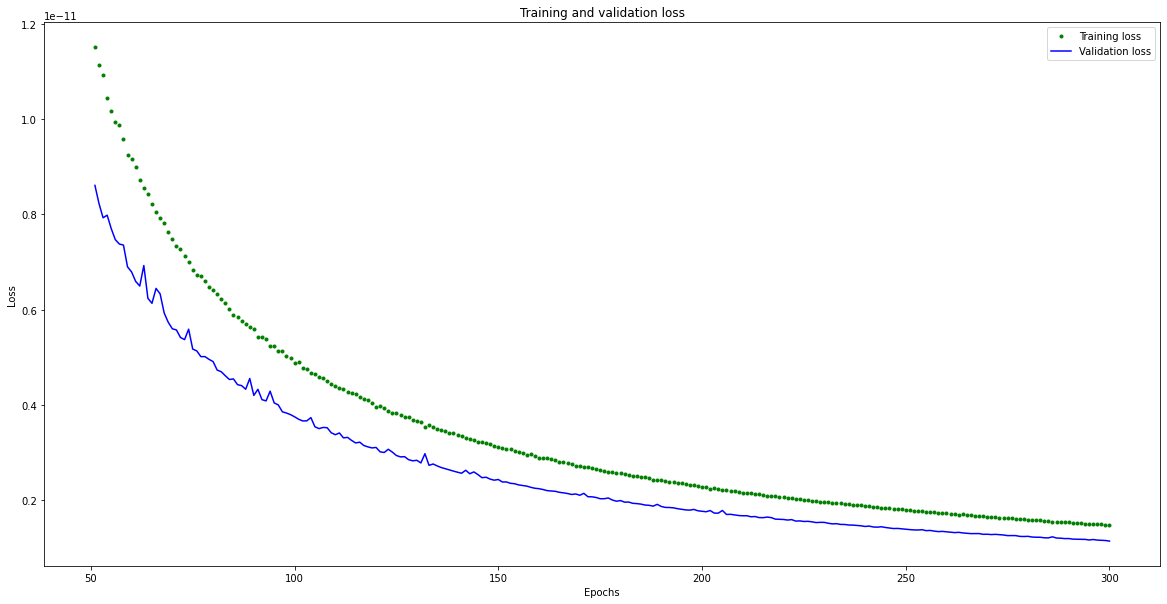

[20.0, 10.0]


In [ ]:
SKIP = 50

# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss8 = history8.history['loss']
val_loss8 = history8.history['val_loss']
epochs8 = range(1, len(loss8) + 1)
plt.plot(epochs8[SKIP:], loss8[SKIP:], 'g.', label='Training loss')
plt.plot(epochs8[SKIP:], val_loss8[SKIP:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

#### Graphing the Accuracy
Graph the Accuracy to judge the performance of the model.

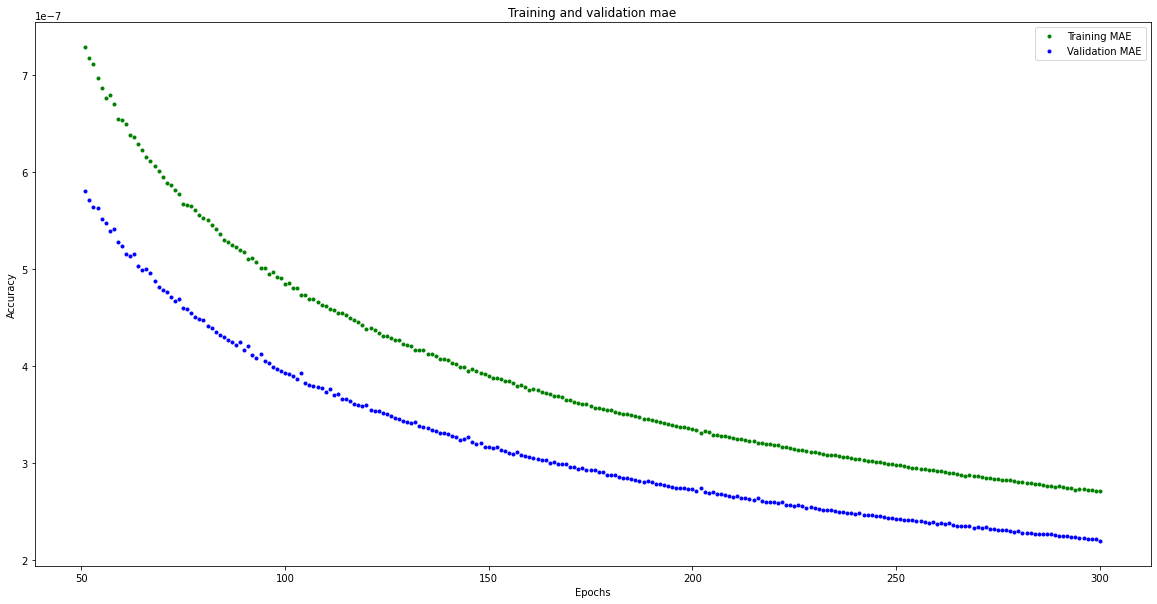

In [ ]:
# graph of mean absolute error
mae8 = history8.history['mae']
val_mae8 = history8.history['val_mae']
plt.plot(epochs8[SKIP:], mae8[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs8[SKIP:], val_mae8[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Comments:
- Increased neuron count per layer does not always improve performance.
- It will, however, increase model file size and complexity significantly.
- Therefore, this model isn't recommended for deployment in microcontrollers.

## Conclusion:
- Model 5 is currently the best model for training; it manages to get the lowest error rate among all the models studied.
* However, the model requires might more space while resulting in minimal gains compared to Model 4.
- If not taking into consideration of time and computational requirements, Model 8 is also a good choice.

#### Chosen model for deployment: Model 4

In [ ]:
model = model4

## Converting the Train Model to TFLite 
This converts the model to TFLite format, with the size (in bytes) of the model printed out.

### Without Quantization

In [ ]:
#Convert the model to TensorFlow Lite Format, without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model_no_quan = converter.convert()

#Save the model to disk
open("gesture_model_no_quan.tflite", "wb").write(tflite_model_no_quan)

model_size1 = os.path.getsize("gesture_model_no_quan.tflite")
print("Model is %d bytes" %model_size1)

INFO:tensorflow:Assets written to: /tmp/tmpwdl1d8h6/assets


Model is 91592 bytes


### With Dynamic (default) Quantization

In [ ]:
#Convert the model to TFLite Format, with Dynamic quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)

#Set the optimization flag to default
#Method: Float to Integer Quantization for Weights
converter.optimzations = [tf.lite.Optimize.DEFAULT]

#Convert the model
tflite_model_dyn_quan = converter.convert()

#Save the model to disk
open("gesture_model_dyn_quan.tflite", "wb").write(tflite_model_dyn_quan)

model_size2 = os.path.getsize("gesture_model_dyn_quan.tflite")
print("Model is %d bytes" %model_size2)

INFO:tensorflow:Assets written to: /tmp/tmp0wk_dy27/assets


INFO:tensorflow:Assets written to: /tmp/tmp0wk_dy27/assets


Model is 91592 bytes


### With Full Integer Quantization

In [ ]:
# Define a generator function, to estimate range of input
# Yield returns the test data for converter to estimate the range required to quantize
def representative_dataset_generator(): 
    for value in inputs_test: 
        yield[np.array(value, dtype = np.float32, ndmin = 2)] 
 
#Convert the model to TensorFlow Lite format with Full Int Quantization 
converter = tf.lite.TFLiteConverter.from_keras_model(model) 
 
#Set the optimization flag - DEFAULT for Float to Int for Weights. 
converter.optimizations = [tf.lite.Optimize.DEFAULT] 
 
#Generate the representative dataset to ensure quantize is done correctly 
converter.representative_dataset = representative_dataset_generator 
 
#Convert the model 
tflite_model_full_quan = converter.convert() 
 
#Save the model to disk (@C:\User\...) 
open("gesture_model_full_quan.tflite", "wb").write(tflite_model_full_quan)

model_size3 = os.path.getsize("gesture_model_full_quan.tflite")
print("Model is %d bytes" %model_size3)

INFO:tensorflow:Assets written to: /tmp/tmpw5yl8dax/assets


INFO:tensorflow:Assets written to: /tmp/tmpw5yl8dax/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Model is 25160 bytes


## Converting TFLite model to C File for deployment

### Convert HEX to C code
Similar to xxd in Linux

In [ ]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

### Without Quantization

In [ ]:
#Write TFLite model to C Source (or Header) file
with open("gesture_model_no_quan.h", 'w') as file:
    file.write(hex_to_c_array(tflite_model_no_quan, "gesture_model_no_quan"))

### With Dynamic Quantization

In [ ]:
#Write TFLite model to C Source (or Header) file
with open("gesture_model_dyn_quan.h", 'w') as file:
    file.write(hex_to_c_array(tflite_model_dyn_quan, "gesture_model_dyn_quan"))

### With Full Integer Quantization

In [ ]:
#Write TFLite model to C Source (or Header) file
with open("gesture_model_full_quan.h", 'w') as file:
    file.write(hex_to_c_array(tflite_model_full_quan, "gesture_model_full_quan"))